In [1]:
import os
from os import listdir
import numpy as np
import nibabel as nib #for reading .nii.gz format MRI files
import matplotlib.pyplot as plt
import pandas as pd
#import cv2 #opencv

In [2]:
import timm
import torch

/Users/rita/anaconda3/envs/hfenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Take a look at models

In [6]:
# default model with classifier
m0 = timm.create_model("mobilevit_xxs.cvnets_in1k", pretrained=True)
print(m0)

ByobNet(
  (stem): ConvNormAct(
    (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn): BatchNormAct2d(
      16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
  )
  (stages): Sequential(
    (0): Sequential(
      (0): BottleneckBlock(
        (shortcut): Identity()
        (conv1_1x1): ConvNormAct(
          (conv): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
        )
        (conv2_kxk): ConvNormAct(
          (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
          

In [12]:
# We want Penultimate Layer Features (Pre-Classifier Features), not classification
# this one ends with:
#   (fc): Identity()
#   (flatten): Identity()
m1 = timm.create_model(
    "mobilevit_xxs.cvnets_in1k", 
    pretrained=True, 
    num_classes=0, 
    global_pool='')


# pretrained weights need <batch B, 3 channels, H, W>:
# ex. (1, 3, 224, 224) -> torch.Size([1,1000]) if classifier
# ex.                  -> torch.Size([1, 320, 7, 7]) if preclassifier (no classifier head & pooling)
# ex. (1, 3, 96, 96)   -> torch.Size([1, 320, 3, 3]) if classifier
x = torch.randn(1, 3, 96, 96) 
o = m1(x)  
#print(m1)

In [3]:
# MobileViTv2
# This one with LinearTransformerBlock(...), LinearSelfAttention(...) classes 
#   crop_pct=0.888?
m2 = timm.create_model("mobilevitv2_050.cvnets_in1k", pretrained=True, num_classes=0, global_pool='')

# pretrained weights need <batch B, 3 channels, H, W>:
# ex. (1, 3, 224, 224) -> torch.Size([1,1000]) if classifier
# ex.                  -> torch.Size([1, 256, 8, 8]) if preclassifier (no classifier head & pooling)
# ex. (1, 3, 96, 96)   -> torch.Size([1, 256, 4, 4]) if classifier
x = torch.randn(1, 3, 224, 224) 
o = m2(x)
print(o.shape)  
#print(m2)

torch.Size([1, 256, 8, 8])


### Load Images from csv

In [63]:
#os.chdir("/Users/rita/Desktop")
#cwd = os.getcwd() #/Users/rita/Desktop/
#print(cwd)

file_dir = 'harini_lab/PROSTATEx/Files/lesions/'
csvFile_image = pd.read_csv(os.path.join(file_dir,'image_list.csv'))
csvFile_score = pd.read_csv(os.path.join(file_dir,'prostatex_classes.csv'))

img_dir_ADC = os.path.join(file_dir, 'Images/ADC') #lesions/Images/ADC/X.nii.gz
img_dir_T2 = os.path.join(file_dir, 'Images/T2') #lesions/Images/T2/X.nii.gz


/Users/rita/Desktop


(384, 384, 3)


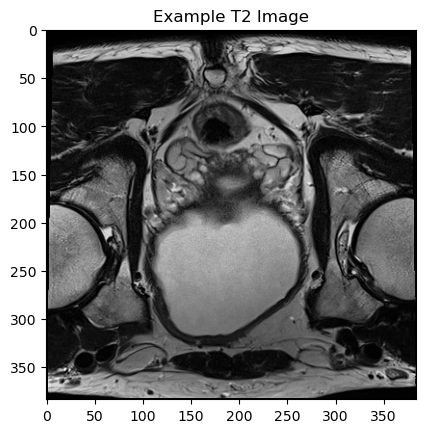

In [72]:
# example images
img_filename_ADC, img_filename_T2 = csvFile_image.iloc[10] #change for different imgs

img_complete_path_ADC = os.path.join(img_dir_ADC, img_filename_ADC) + '.nii.gz'
img_ADC = nib.load(img_complete_path_ADC)
imgdata_ADC = img_ADC.get_fdata() #(84, 128, 19)

slice_ADC = imgdata_ADC[:,:,14] #(mask at 13~17) #(84,128)
#plt.imshow(slice_ADC.T, cmap='Greys_r'); plt.title("Example ADC Image")

img_complete_path_T2 = os.path.join(img_dir_T2, img_filename_T2) + '.nii.gz'
img_T2 = nib.load(img_complete_path_T2)
imgdata_T2 = img_T2.get_fdata() #(384, 384, 19)

slice_T2 = imgdata_T2[:,:,13:16] #changed
plt.imshow(slice_T2[:,:,2].T, cmap='Greys_r'); plt.title("Example T2 Image")
print(slice_T2.shape) 

In [ ]:
# save
np.save('ex_multi_slice_T2', slice_T2)

### Playground

In [79]:
#load example image
slice_T2 = np.load('ex_multi_slice_T2.npy') 
#plt.imshow(slice_T2.T, cmap='Greys_r'); plt.title("Example T2 Image")
#slice_T2 = slice_T2.transpose(2,0,1)
#print(slice_T2.shape) #plt.imshow(slice_T2[1,:,:].T, cmap='Greys_r'); plt.title("Example T2 Image")


In [15]:
# Example code from HF (Image Classification)
from urllib.request import urlopen
from PIL import Image
#import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model('mobilevitv2_050.cvnets_in1k', pretrained=True)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

x = transforms(img).unsqueeze(0)
output = model(x)  # unsqueeze single image into batch of 1

top5_probabilities, top5_class_indices = torch.topk(output.softmax(dim=1) * 100, k=5)


torch.Size([1, 3, 256, 256])


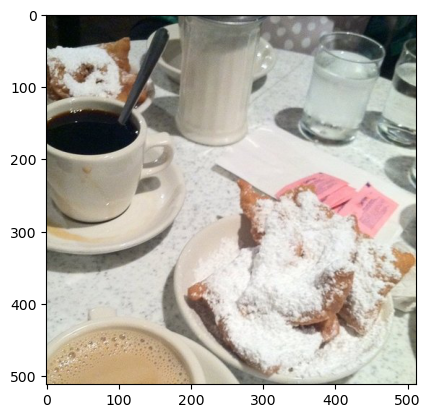

In [16]:
plt.imshow(img)
print(x.shape) #[1, 3, 256, 256]
#print(output)             #shape: [1, 1000]
#print(top5_class_indices) #[969, 967, 928, 960, 927]   shape: [1, 5]
#print(top5_probabilities) #[24.9318, 12.4587,  8.9054,  6.5909,  5.6044]  shape:[1, 5]

In [78]:
print(img.shape)

AttributeError: 'PngImageFile' object has no attribute 'shape'

In [17]:
# Example code from HF (Feature Map Extraction)
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'mobilevitv2_050.cvnets_in1k',
    pretrained=True,
    features_only=True,
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # unsqueeze single image into batch of 1

for o in output:
    # print shape of each feature map in output
    # e.g.:
    #  torch.Size([1, 32, 128, 128])
    #  torch.Size([1, 64, 64, 64])
    #  torch.Size([1, 128, 32, 32])
    #  torch.Size([1, 192, 16, 16])
    #  torch.Size([1, 256, 8, 8])

    print(o.shape)


torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 192, 16, 16])
torch.Size([1, 256, 8, 8])


In [ ]:
# visualize feature map
processed = []

for feature_map in output:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0]
    fm = gray_scale.data.cpu().numpy()
    processed.append(fm)

    print(fm.shape)
    #(128, 128)
    #(64, 64)
    #(32, 32)
    #(16, 16)
    #(8, 8)

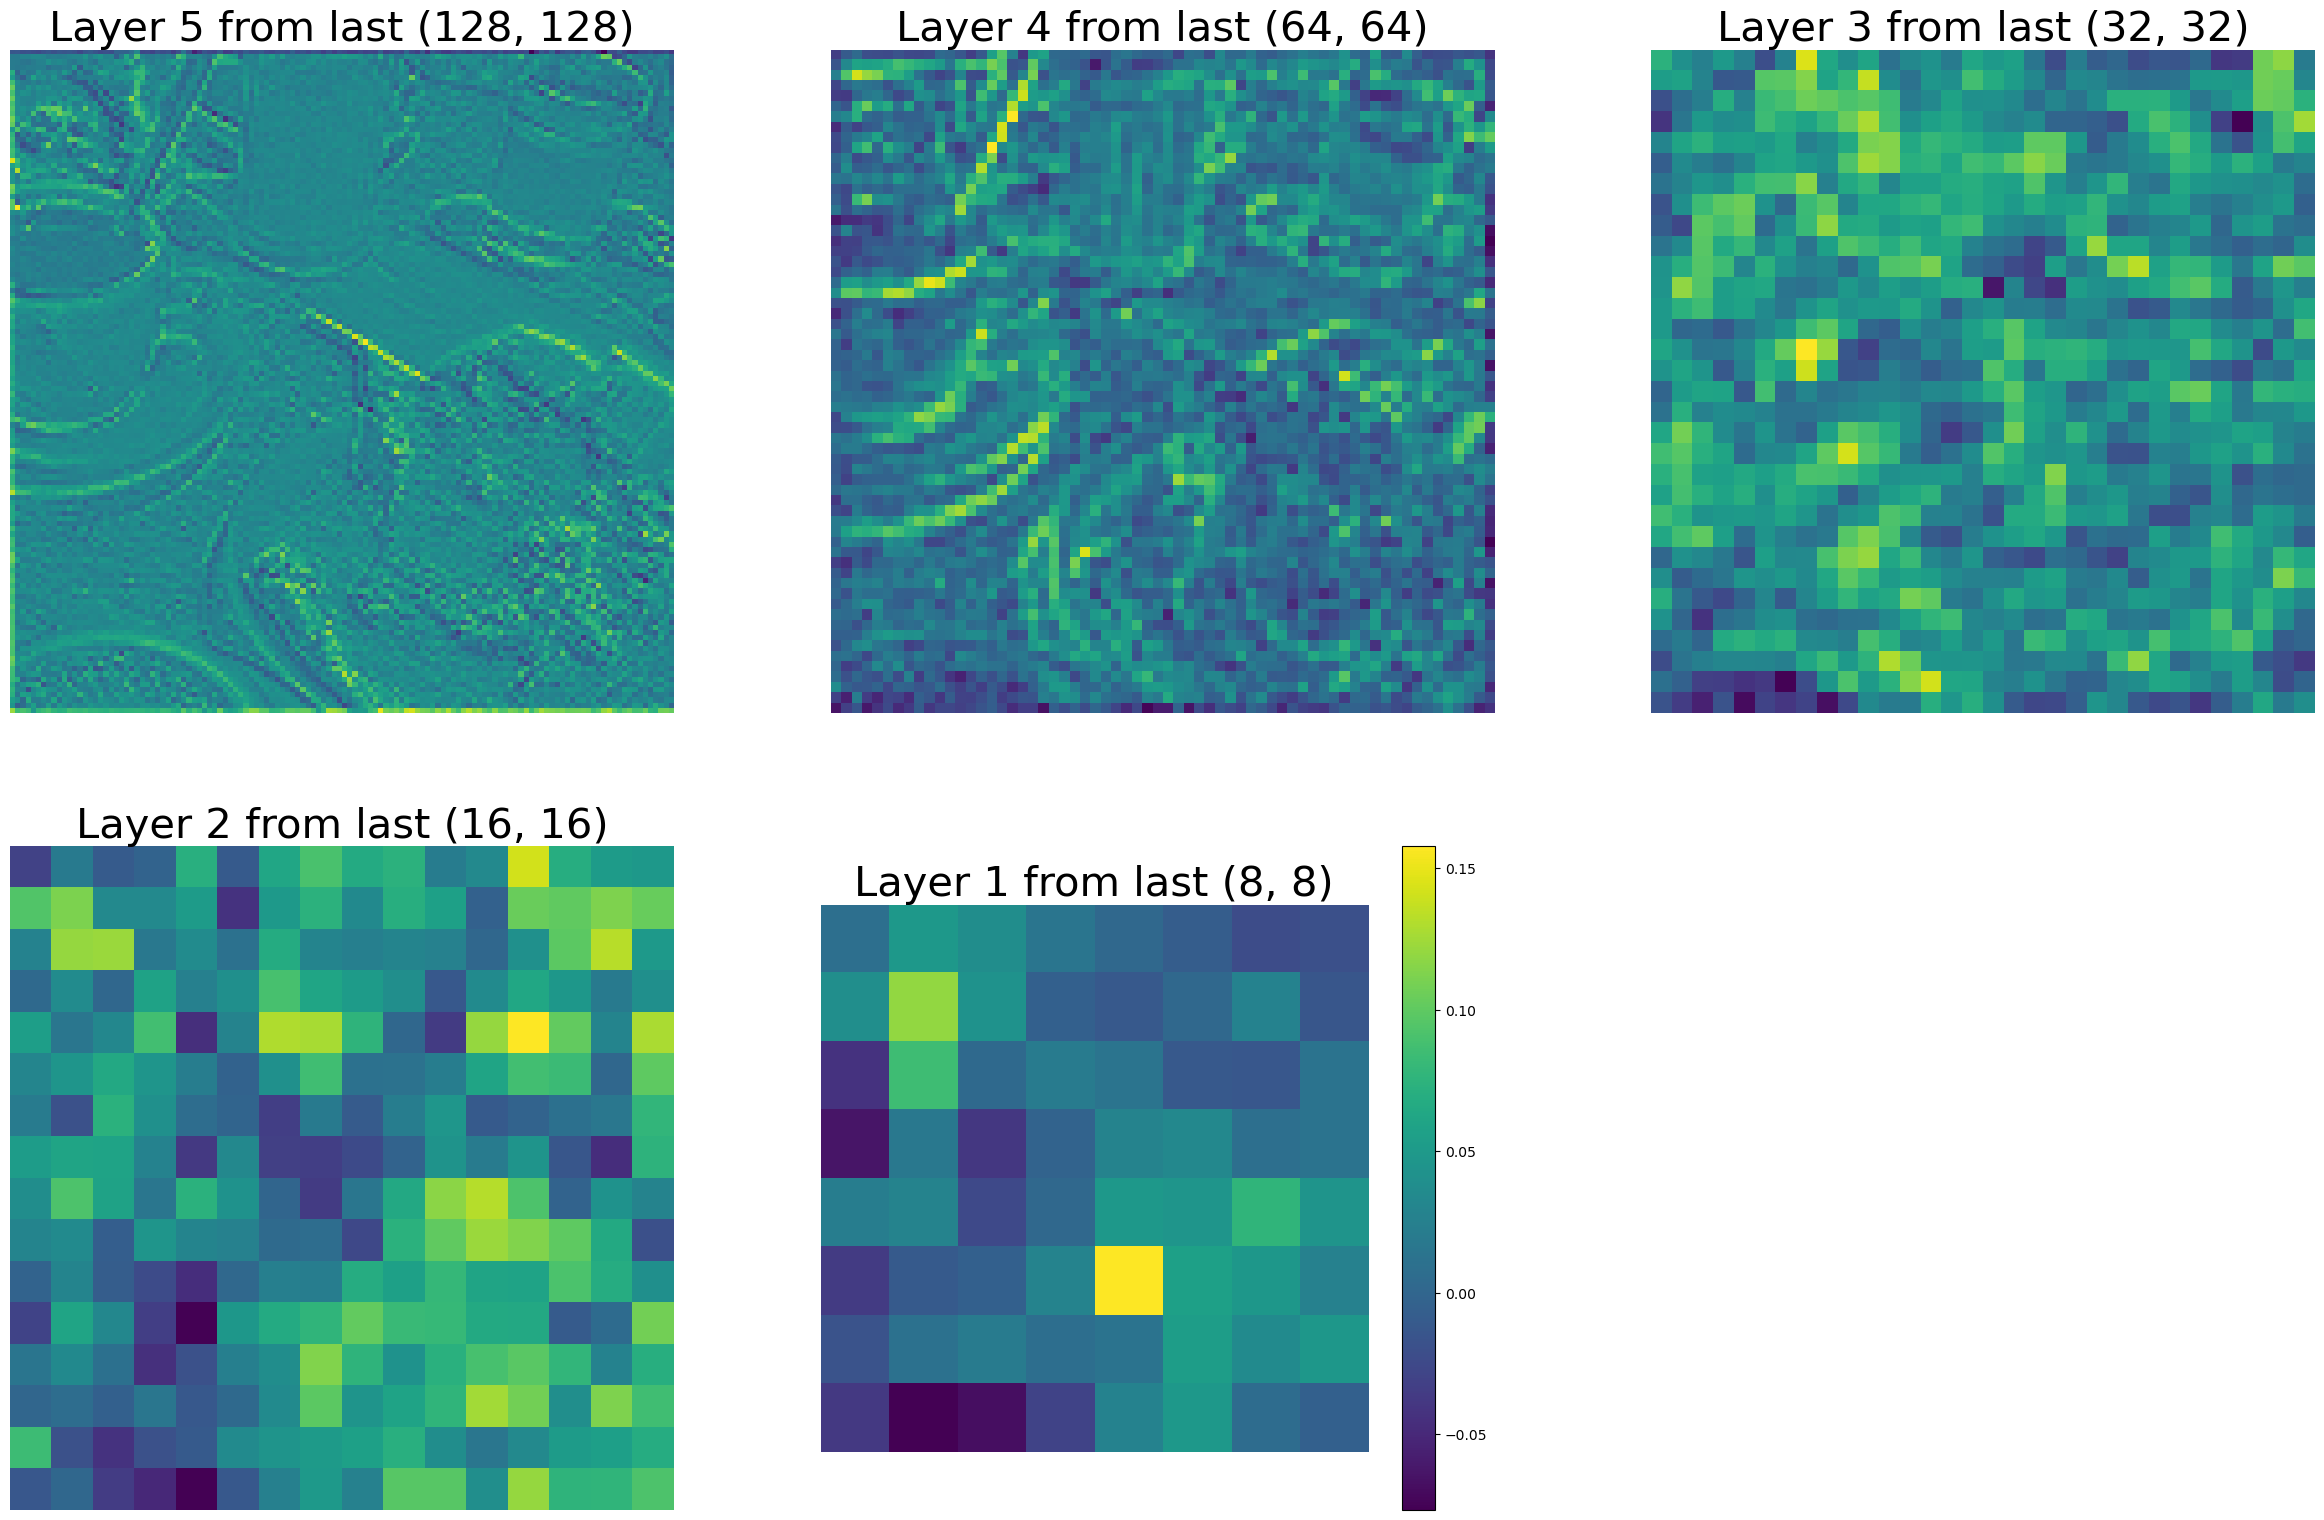

In [41]:
fig = plt.figure(figsize=(30, 50))
for i in range(len(processed)):
    a = fig.add_subplot(5, 3, i+1)
    imgplot = plt.imshow(processed[i])
    a.axis("off")
    a.set_title("Layer {} from last {}".format(len(processed)-i, processed[i].shape), fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
cbar = plt.colorbar()

In [43]:
# Example code from HF (Image Embedding)
from urllib.request import urlopen
from PIL import Image
import timm

img = Image.open(urlopen(
    'https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png'
))

model = timm.create_model(
    'mobilevitv2_050.cvnets_in1k',
    pretrained=True,
    num_classes=0,  # remove classifier nn.Linear, but still have global pooling?
)
model = model.eval()

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)

output = model(transforms(img).unsqueeze(0))  # output is (batch_size, num_features) = [1, 256] tensor

# or equivalently (without needing to set num_classes=0)
#output = model.forward_features(transforms(img).unsqueeze(0)) #(1, 256, 8, 8) tensor
#output = model.forward_head(output, pre_logits=True) #(1, num_features) tensor


tensor([[-5.2921e-01,  4.0285e-05,  2.8179e-04, -2.9105e-01, -1.8466e-04,
          2.5334e-01,  2.3885e-01,  1.0111e-04, -1.5886e-01,  2.0853e-04,
          1.7585e-04, -1.0689e-04, -3.0941e-04,  3.5291e-01, -3.7270e-01,
          2.9007e-05, -3.6279e-04, -4.1592e-01,  4.1182e-01, -3.6627e-01,
         -5.5535e-04, -4.4077e-04,  6.3093e-02, -2.7757e-04,  2.0582e-04,
          2.2039e-01, -4.5678e-02, -4.4968e-01, -1.2480e-01, -2.5385e-02,
         -8.6841e-04,  1.1906e-01,  9.5126e-01, -2.7840e-01,  5.1453e-01,
          4.1039e-02, -1.6968e-05, -2.1932e-04,  3.0808e-04,  3.9655e-01,
          1.2089e-01,  5.7860e-04, -6.3158e-01,  1.9179e-01,  2.9559e-01,
         -6.2259e-01,  3.1135e-04,  3.0120e-01,  1.1824e-03,  2.6114e-01,
          4.1490e-01, -7.7583e-04, -7.1650e-02,  3.3679e-04,  2.7152e-01,
         -2.4777e-01, -7.7371e-05,  4.2789e-04,  1.5802e-01,  1.3225e-01,
         -1.7540e-04,  5.3309e-04,  2.2595e-04,  3.2320e-01,  3.9446e-01,
         -2.8360e-04, -1.5405e-01, -4.

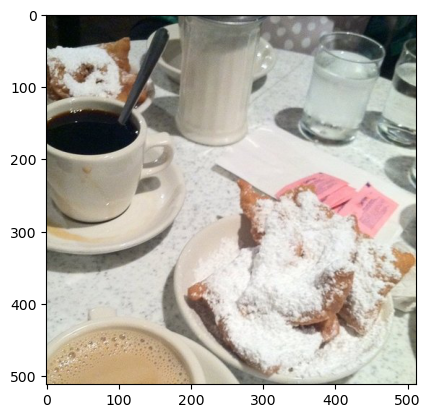

In [46]:
plt.imshow(img)
print(output)

### Visualize Feature map

In [81]:
import torchvision.transforms as trans
# Feature map
m2 = timm.create_model(
    'mobilevitv2_050.cvnets_in1k', 
    features_only=True, 
    pretrained=True)

# get model specific transforms (normalization, resize)
data_config = timm.data.resolve_model_data_config(m2)
transforms = timm.data.create_transform(**data_config, is_training=False)

# torchvision transforms module takes PIL image with 3 channels, need to add lines
pil_image = trans.ToPILImage()(slice_T2)
x = transforms(pil_image).unsqueeze(0) #torch.Size([1, 3, 256, 256])
output = m2(x) #list with len=5 tensors

for o in output:
    # print shape of each feature map in output
    # e.g.:
    #  torch.Size([1, 32, 128, 128])
    #  torch.Size([1, 64, 64, 64])
    #  torch.Size([1, 128, 32, 32])
    #  torch.Size([1, 192, 16, 16])
    #  torch.Size([1, 256, 8, 8])

    print(o.shape)


x.shape = torch.Size([1, 3, 256, 256])
torch.Size([1, 32, 128, 128])
torch.Size([1, 64, 64, 64])
torch.Size([1, 128, 32, 32])
torch.Size([1, 192, 16, 16])
torch.Size([1, 256, 8, 8])


In [82]:
# visualize feature map
fms = []

for feature_map in output:
    feature_map = feature_map.squeeze(0)
    gray_scale = torch.sum(feature_map,0)
    gray_scale = gray_scale / feature_map.shape[0] #feature_map.shape[0] = 32,64,128,192,256
    fm = gray_scale.data.cpu().numpy()
    fms.append(fm)

    print(fm.shape)
    # the feature map become smaller and contain more information, "folding"???
    #(128, 128)
    #(64, 64)
    #(32, 32)
    #(16, 16)
    #(8, 8)

(128, 128)
(64, 64)
(32, 32)
(16, 16)
(8, 8)


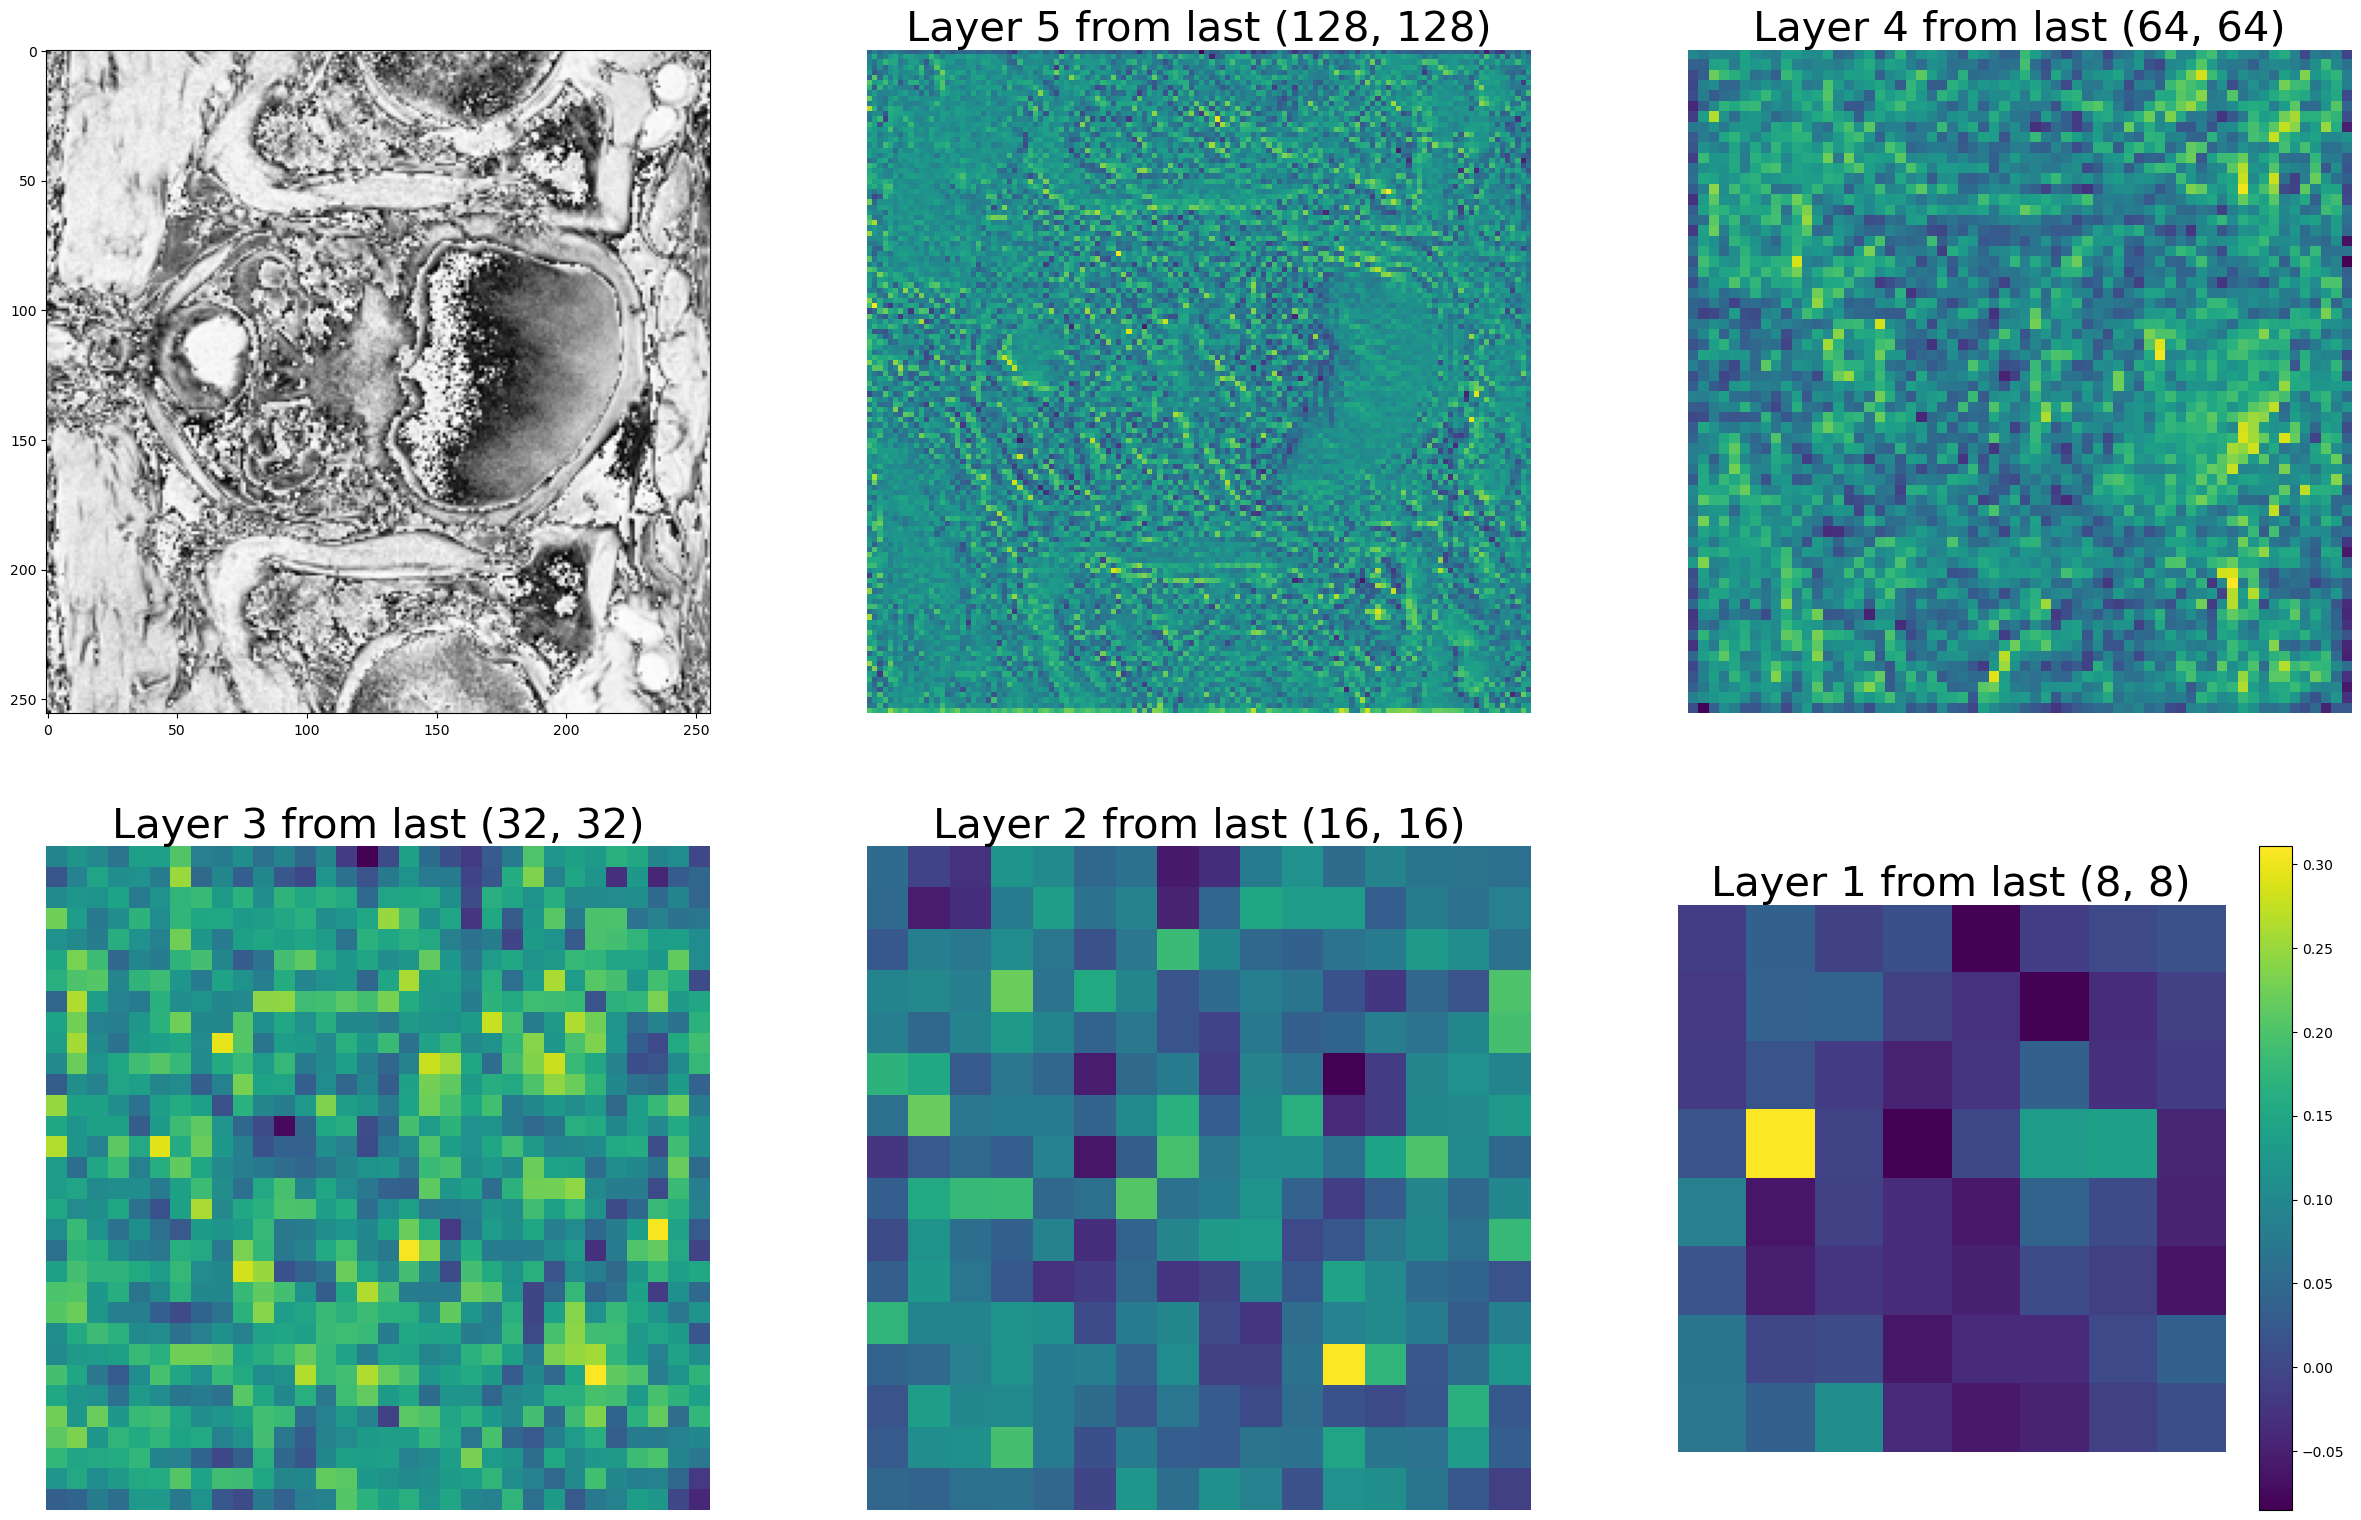

In [87]:
fig = plt.figure(figsize=(30, 50))
fig.add_subplot(5, 3, 1)
ori = plt.imshow(x.squeeze(0)[1,:,:], cmap='Greys_r')

for i in range(len(fms)):
    a = fig.add_subplot(5, 3, i+2)
    imgplot = plt.imshow(fms[i])
    a.axis("off")
    a.set_title("Layer {} from last {}".format(len(fms)-i, fms[i].shape), fontsize=30)
#plt.savefig(str('feature_maps.jpg'), bbox_inches='tight')
cbar = plt.colorbar()

### Example Codes from HF
https://huggingface.co/timm/mobilevitv2_050.cvnets_in1k 